# Sports League Optimization: Comparative Analysis of Algorithms

This notebook presents a comprehensive analysis of different optimization algorithms applied to the Sports League problem. We compare Hill Climbing, Simulated Annealing, and Genetic Algorithm approaches, analyzing their performance across multiple metrics.

## Table of Contents
1. [Problem Definition](#1-problem-definition)
2. [Experimental Setup](#2-experimental-setup)
3. [Algorithm Implementations](#3-algorithm-implementations)
4. [Performance Comparison](#4-performance-comparison)
5. [Statistical Analysis](#5-statistical-analysis)
6. [Conclusion](#6-conclusion)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
import random
from copy import deepcopy
import os
import concurrent.futures
from datetime import datetime
import scikit_posthocs as sp

# Import our custom modules
from solution import LeagueSolution, LeagueHillClimbingSolution, LeagueSASolution
from evolution import (
    hill_climbing, 
    simulated_annealing, 
    genetic_algorithm,
    # Mutation operators
    mutate_swap,
    mutate_swap_constrained,
    mutate_team_shift,
    mutate_targeted_player_exchange,
    mutate_shuffle_within_team_constrained,
    # Crossover operators
    crossover_one_point,
    crossover_one_point_prefer_valid,
    crossover_uniform,
    crossover_uniform_prefer_valid,
    # Selection operators
    selection_tournament,
    selection_tournament_variable_k,
    selection_ranking,
    selection_boltzmann
)
# Import the fitness counter module
from fitness_counter import fitness_counter

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## 1. Problem Definition

### 1.1 Sports League Problem

The Sports League problem involves assigning players to teams while satisfying specific constraints and optimizing for team balance. The goal is to create teams with similar average skill levels.

**Formal Definition:**
- We have 35 players with different positions (GK, DEF, MID, FWD) and skill levels
- We need to assign these players to 5 teams (7 players per team)
- Each team must have exactly 1 GK, 2 DEF, 2 MID, and 2 FWD
- Each team's total salary must not exceed 750M €
- The objective is to minimize the standard deviation of average team skills

### 1.2 Solution Representation

We represent a solution as a list of team assignments for each player. For example, if `solution.repr[0] = 2`, it means player 0 is assigned to team 2.

**Search Space Size:**
- For 35 players and 5 teams, the theoretical search space is 5^35
- With constraints, the actual feasible search space is much smaller, but still extremely large

### 1.3 Fitness Function

The fitness function calculates the standard deviation of the average skill levels across all teams. A lower value indicates more balanced teams, which is our optimization goal.

For invalid solutions (those violating constraints), we return infinity to ensure they are never selected.

In [2]:
# Load player data
players_df = pd.read_csv("players.csv", sep=";")
# Rename the salary column to match the code expectations
players_df = players_df.rename(columns={'Salary (€M)': 'Salary'})
players_data = players_df.to_dict(orient="records")

# Display the player data
players_df

,Unnamed: 0,Name,Position,Skill,Salary
0,0,Alex Carter,GK,85,90
1,1,Jordan Smith,GK,88,100
2,2,Ryan Mitchell,GK,83,85
3,3,Chris Thompson,GK,80,80
4,4,Blake Henderson,GK,87,95
5,5,Daniel Foster,DEF,90,110
6,6,Lucas Bennett,DEF,85,90
7,7,Owen Parker,DEF,88,100
8,8,Ethan Howard,DEF,80,70
9,9,Mason Reed,DEF,82,75


### 1.4 Data Analysis

Let's analyze the player data to understand the distribution of skills, positions, and salaries.

Position distribution:
Position
DEF    10
MID    10
FWD    10
GK      5
Name: count, dtype: int64


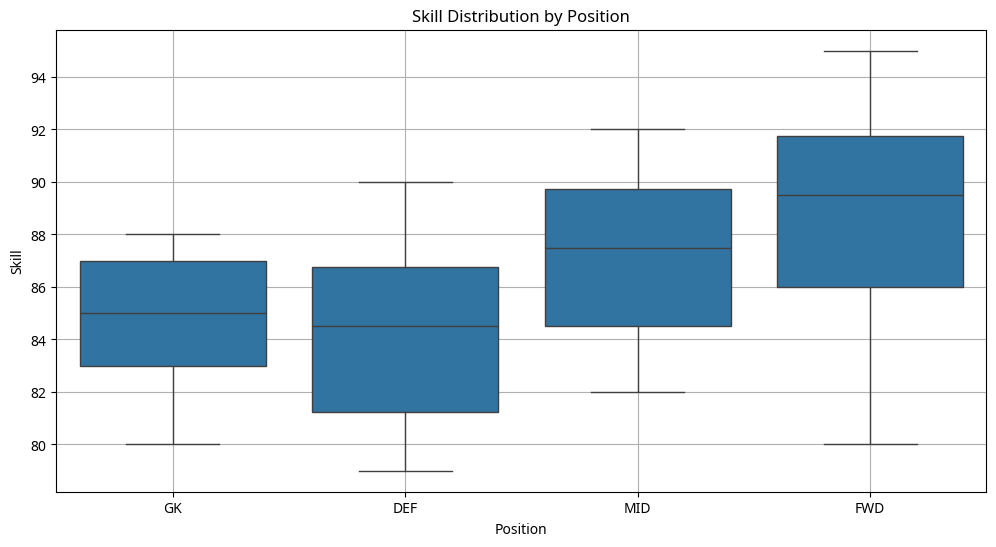

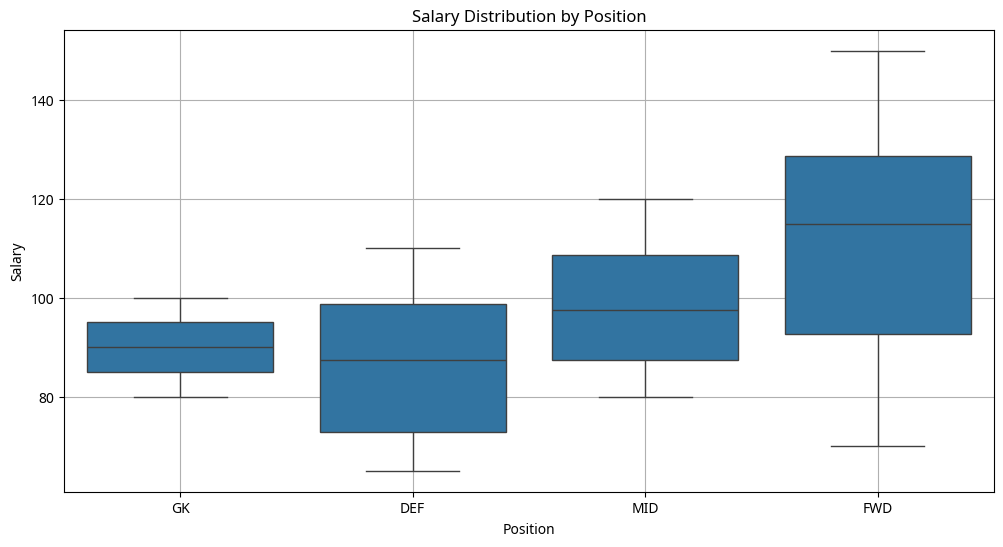

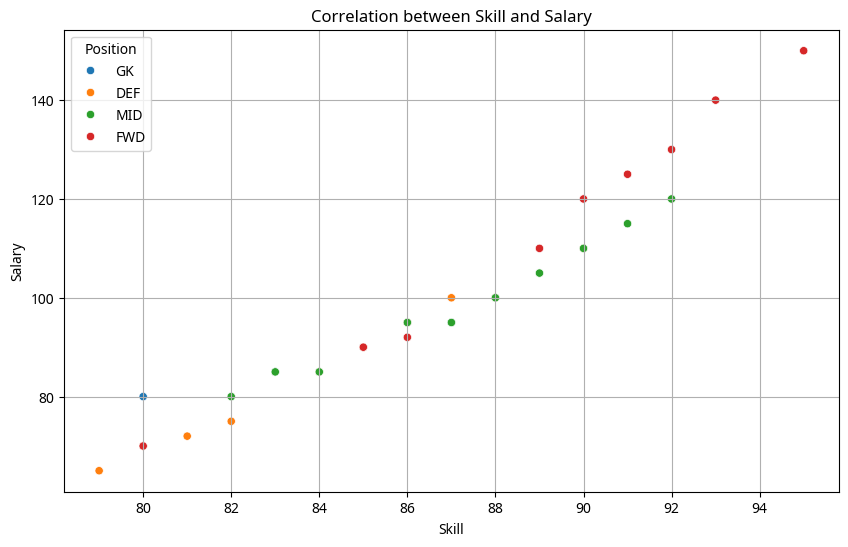

In [3]:
# Analyze player positions
position_counts = players_df['Position'].value_counts()
print("Position distribution:")
print(position_counts)

# Analyze skill distribution by position
plt.figure(figsize=(12, 6))
sns.boxplot(x='Position', y='Skill', data=players_df)
plt.title('Skill Distribution by Position')
plt.grid(True)
plt.show()

# Analyze salary distribution by position
plt.figure(figsize=(12, 6))
sns.boxplot(x='Position', y='Salary', data=players_df)
plt.title('Salary Distribution by Position')
plt.grid(True)
plt.show()

# Correlation between skill and salary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Skill', y='Salary', hue='Position', data=players_df)
plt.title('Correlation between Skill and Salary')
plt.grid(True)
plt.show()

## 2. Experimental Setup

### 2.1 Metrics for Comparison

To ensure a fair comparison between different algorithms, we'll track the following metrics:

1. **Solution Quality**: The fitness value (standard deviation of average team skills)
2. **Function Evaluations**: Number of fitness function calls
3. **Iterations**: Number of algorithm iterations
4. **Runtime**: Actual execution time in seconds

### 2.2 Algorithm Configurations

We'll test the following algorithm configurations:

In [4]:
# Helper function to generate valid initial solutions using a robust heuristic approach
def generate_valid_solution(solution_class, players_data, max_attempts=500000, verbose=False):
    """
    Generate a valid initial solution for any solution class using a robust heuristic approach.
    
    Args:
        solution_class: The solution class to instantiate
        players_data: List of player dictionaries
        max_attempts: Maximum number of attempts to generate a valid solution
        verbose: Whether to print progress information
        
    Returns:
        A valid solution instance or None if no valid solution could be found
    """
    # Track attempts for diagnostics
    random_attempts = 0
    heuristic_attempts = 0
    swap_attempts = 0
    
    # First try the standard random approach with increased attempts
    for _ in range(5000):  # Try more random solutions first
        random_attempts += 1
        solution = solution_class(players=players_data)
        if solution.is_valid():
            if verbose:
                print(f"Found valid solution with random approach after {random_attempts} attempts")
            return solution
    
    if verbose:
        print("Using heuristic construction approach for valid solution generation...")
    
    # Try multiple heuristic construction attempts with different team orders
    for heuristic_try in range(20):  # Try multiple heuristic constructions with different randomization
        heuristic_attempts += 1
        
        # Group players by position
        players_by_position = {}
        for i, player in enumerate(players_data):
            pos = player['Position']
            if pos not in players_by_position:
                players_by_position[pos] = []
            players_by_position[pos].append((i, player))
        
        # Shuffle players within each position to increase diversity
        for pos in players_by_position:
            random.shuffle(players_by_position[pos])
        
        # Create a new solution instance
        solution = solution_class(players=players_data)
        
        # Reset all assignments
        for i in range(len(solution.repr)):
            solution.repr[i] = -1  # -1 means unassigned
        
        # Number of teams
        num_teams = 5
        
        # Create a randomized team order for assignments to increase diversity
        team_order = list(range(num_teams))
        random.shuffle(team_order)
        
        # Assign players to teams using a balanced approach with randomized team order
        # First, assign goalkeepers (1 per team)
        for team_idx, team_id in enumerate(team_order):
            if team_idx < len(players_by_position.get('GK', [])):
                player_idx = players_by_position['GK'][team_idx][0]
                solution.repr[player_idx] = team_id
        
        # Assign defenders (2 per team)
        for team_idx, team_id in enumerate(team_order):
            defenders_assigned = 0
            for player_tuple in players_by_position.get('DEF', []):
                player_idx = player_tuple[0]
                if solution.repr[player_idx] == -1:  # If player not assigned yet
                    solution.repr[player_idx] = team_id
                    defenders_assigned += 1
                    if defenders_assigned == 2:  # 2 defenders per team
                        break
        
        # Assign midfielders (2 per team)
        for team_idx, team_id in enumerate(team_order):
            midfielders_assigned = 0
            for player_tuple in players_by_position.get('MID', []):
                player_idx = player_tuple[0]
                if solution.repr[player_idx] == -1:  # If player not assigned yet
                    solution.repr[player_idx] = team_id
                    midfielders_assigned += 1
                    if midfielders_assigned == 2:  # 2 midfielders per team
                        break
        
        # Assign forwards (2 per team)
        for team_idx, team_id in enumerate(team_order):
            forwards_assigned = 0
            for player_tuple in players_by_position.get('FWD', []):
                player_idx = player_tuple[0]
                if solution.repr[player_idx] == -1:  # If player not assigned yet
                    solution.repr[player_idx] = team_id
                    forwards_assigned += 1
                    if forwards_assigned == 2:  # 2 forwards per team
                        break
        
        # Check if all players are assigned
        if -1 in solution.repr:
            # Assign remaining players to balance teams
            for i in range(len(solution.repr)):
                if solution.repr[i] == -1:
                    # Find team with fewest players
                    team_counts = [0] * num_teams
                    for team_id in solution.repr:
                        if team_id != -1:
                            team_counts[team_id] += 1
                    solution.repr[i] = team_counts.index(min(team_counts))
        
        # Check if solution is valid
        if solution.is_valid():
            if verbose:
                print(f"Found valid solution with heuristic approach after {heuristic_attempts} attempts")
            return solution
        
        # If heuristic approach fails, try to fix salary constraints
        # Calculate team salaries
        team_salaries = [0] * num_teams
        team_positions = [{pos: 0 for pos in ['GK', 'DEF', 'MID', 'FWD']} for _ in range(num_teams)]
        
        for i, team_id in enumerate(solution.repr):
            if team_id >= 0:  # Skip unassigned players
                team_salaries[team_id] += players_data[i]['Salary']
                team_positions[team_id][players_data[i]['Position']] += 1
        
        # Try to swap players to satisfy salary constraints
        max_salary = 750  # Maximum salary per team
        
        # More aggressive swapping strategy with multiple passes
        for swap_pass in range(3):  # Try multiple passes of swaps
            made_improvement = False
            
            # Try to fix position constraints first
            for team_id in range(num_teams):
                for pos, count in team_positions[team_id].items():
                    required = {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2}[pos]
                    
                    # If we have too many of this position
                    while count > required:
                        # Find another team that needs this position
                        for other_team in range(num_teams):
                            if other_team != team_id and team_positions[other_team][pos] < required:
                                # Find a player of this position in our team
                                for i, player_team in enumerate(solution.repr):
                                    if player_team == team_id and players_data[i]['Position'] == pos:
                                        # Swap this player to the other team
                                        solution.repr[i] = other_team
                                        team_positions[team_id][pos] -= 1
                                        team_positions[other_team][pos] += 1
                                        team_salaries[team_id] -= players_data[i]['Salary']
                                        team_salaries[other_team] += players_data[i]['Salary']
                                        count -= 1
                                        made_improvement = True
                                        break
                                if count <= required:
                                    break
            
            # Try to fix salary constraints
            for attempt in range(1000):  # More attempts per pass
                swap_attempts += 1
                
                # Find teams that exceed salary cap
                over_budget_teams = [i for i, salary in enumerate(team_salaries) if salary > max_salary]
                if not over_budget_teams:  # All teams within budget
                    break
                    
                # Find teams under budget
                under_budget_teams = [i for i, salary in enumerate(team_salaries) if salary <= max_salary]
                if not under_budget_teams:  # All teams over budget
                    break
                    
                # Select a team over budget and a team under budget
                over_team = random.choice(over_budget_teams)
                under_team = random.choice(under_budget_teams)
                
                # Find players in these teams
                over_team_players = [(i, players_data[i]) for i in range(len(solution.repr)) if solution.repr[i] == over_team]
                under_team_players = [(i, players_data[i]) for i in range(len(solution.repr)) if solution.repr[i] == under_team]
                
                # Sort players by salary (descending) to prioritize high-salary swaps
                over_team_players.sort(key=lambda x: x[1]['Salary'], reverse=True)
                
                # Try to find a pair of players to swap that would improve salary balance
                for over_idx, over_player in over_team_players:
                    over_pos = over_player['Position']
                    over_salary = over_player['Salary']
                    
                    # Filter under-team players by position
                    matching_under_players = [(idx, p) for idx, p in under_team_players if p['Position'] == over_pos]
                    
                    for under_idx, under_player in matching_under_players:
                        under_salary = under_player['Salary']
                        
                        # Calculate new salaries after swap
                        new_over_salary = team_salaries[over_team] - over_salary + under_salary
                        new_under_salary = team_salaries[under_team] - under_salary + over_salary
                        
                        # If swap improves situation, do it
                        if new_over_salary <= max_salary or new_over_salary < team_salaries[over_team]:
                            # Swap players
                            solution.repr[over_idx] = under_team
                            solution.repr[under_idx] = over_team
                            
                            # Update team salaries
                            team_salaries[over_team] = new_over_salary
                            team_salaries[under_team] = new_under_salary
                            made_improvement = True
                            break
                    
                    if made_improvement:
                        break
                
                # Check if we've made a swap and solution is valid
                if solution.is_valid():
                    if verbose:
                        print(f"Found valid solution after {random_attempts} random attempts, "
                              f"{heuristic_attempts} heuristic attempts, and {swap_attempts} swap attempts")
                    return solution
                
                # If no improvement was made in this pass, move to next pass
                if not made_improvement:
                    break
    
    # If we still don't have a valid solution, try one more random approach with remaining attempts
    remaining_attempts = max_attempts - random_attempts - swap_attempts
    for _ in range(remaining_attempts):
        solution = solution_class(players=players_data)
        if solution.is_valid():
            if verbose:
                print(f"Found valid solution with final random approach after {random_attempts + _ + 1} total random attempts")
            return solution
    
    # If all attempts fail, return None
    if verbose:
        print(f"Failed to find valid solution after {max_attempts} total attempts")
    return None

# Define algorithm configurations
configs = {
    # Hill Climbing configurations
    'HC_Standard': {
        'algorithm': 'Hill Climbing',
        'params': {
            'max_iterations': 500,
            'max_no_improvement': 100,
            'verbose': False
        }
    },
    
    # Hill Climbing with valid initial solution
    'HC_Valid_Initial': {
        'algorithm': 'Hill Climbing Valid',
        'params': {
            'max_iterations': 500,
            'max_no_improvement': 100,
            'verbose': False
        }
    },
    
    # Simulated Annealing configurations
    'SA_Standard': {
        'algorithm': 'Simulated Annealing',
        'params': {
            'initial_temperature': 200.0,
            'cooling_rate': 0.95,
            'min_temperature': 1e-5,
            'iterations_per_temp': 20,
            'verbose': False
        }
    },
    
    # Genetic Algorithm configurations
    'GA_Tournament_OnePoint': {
        'algorithm': 'Genetic Algorithm',
        'params': {
            'population_size': 100,
            'max_generations': 50,
            'selection_operator': selection_tournament,
            'crossover_operator': crossover_one_point_prefer_valid,
            'crossover_rate': 0.8,
            'mutation_operator': mutate_swap_constrained,
            'mutation_rate': 0.1,
            'elitism': True,
            'elitism_size': 2,
            'verbose': False
        }
    },
    
    'GA_Ranking_Uniform': {
        'algorithm': 'Genetic Algorithm',
        'params': {
            'population_size': 100,
            'max_generations': 50,
            'selection_operator': selection_ranking,
            'crossover_operator': crossover_uniform_prefer_valid,
            'crossover_rate': 0.8,
            'mutation_operator': mutate_swap_constrained,
            'mutation_rate': 0.1,
            'elitism': True,
            'elitism_size': 2,
            'verbose': False
        }
    },
    
    'GA_Boltzmann_TeamShift': {
        'algorithm': 'Genetic Algorithm',
        'params': {
            'population_size': 100,
            'max_generations': 50,
            'selection_operator': selection_boltzmann,
            'selection_params': {'temperature': 1.0},
            'crossover_operator': crossover_uniform_prefer_valid,
            'crossover_rate': 0.8,
            'mutation_operator': mutate_team_shift,
            'mutation_rate': 0.1,
            'elitism': True,
            'elitism_size': 2,
            'verbose': False
        }
    },
    
    'GA_Hybrid': {
        'algorithm': 'Hybrid GA',
        'params': {
            'population_size': 75,
            'max_generations': 40,
            'selection_operator': selection_tournament,
            'selection_params': {'k': 3},
            'crossover_operator': crossover_one_point_prefer_valid,
            'crossover_rate': 0.85,
            'mutation_operator': mutate_targeted_player_exchange,
            'mutation_rate': 0.15,
            'elitism': True,
            'elitism_size': 1,
            'local_search': {'algorithm': 'hill_climbing', 'frequency': 5, 'iterations': 50},
            'verbose': False
        }
    }
}

### 2.3 Experiment Setup

We'll run each algorithm configuration multiple times to account for randomness and collect statistics.

In [5]:
# Import solution classes at the top level to ensure they're available in all scopes
from solution import LeagueHillClimbingSolution, LeagueSASolution

# Function to run a single experiment
def run_single_experiment(config_name, run_number, configs, players_data):
    """
    Run a single experiment for a specific configuration and run number.
    
    Args:
        config_name: Name of the configuration to run
        run_number: Run number for this experiment
        configs: Dictionary of all configurations
        players_data: Player data for the experiment
        
    Returns:
        Dictionary with experiment results or error message
    """
    try:
        config = configs[config_name]
        algorithm_name = config['algorithm']
        params = config['params'].copy()
        
        # Reset fitness counter for this experiment
        from fitness_counter import fitness_counter
        
        # Start timing
        start_time = time.time()
        
        # Initialize solution and run algorithm based on configuration
        if algorithm_name == 'Hill Climbing':
            # Standard Hill Climbing with potentially invalid initial solution
            solution = LeagueHillClimbingSolution(players=players_data)
            
            # Start counting fitness evaluations
            fitness_counter.start_counting(LeagueHillClimbingSolution)
            
            # Run Hill Climbing
            best_solution, best_fitness, history = hill_climbing(solution, **params)
            
            # Stop counting fitness evaluations
            evaluations = fitness_counter.stop_counting(LeagueHillClimbingSolution)
            
        elif algorithm_name == 'Hill Climbing Valid':
            # Hill Climbing with guaranteed valid initial solution
            solution = generate_valid_solution(LeagueHillClimbingSolution, players_data, verbose=False)
            
            # If we couldn't generate a valid solution, return error
            if solution is None:
                return {
                    'Configuration': config_name,
                    'Run': run_number,
                    'Fitness': float('inf'),
                    'Evaluations': 0,
                    'Runtime': 0.0,
                    'History': [],
                    'Error': 'Could not generate valid initial solution'
                }
            
            # Start counting fitness evaluations
            fitness_counter.start_counting(LeagueHillClimbingSolution)
            
            # Run Hill Climbing
            best_solution, best_fitness, history = hill_climbing(solution, **params)
            
            # Stop counting fitness evaluations
            evaluations = fitness_counter.stop_counting(LeagueHillClimbingSolution)
            
        elif algorithm_name == 'Simulated Annealing':
            solution = LeagueSASolution(players=players_data)
            
            # Start counting fitness evaluations
            fitness_counter.start_counting(LeagueSASolution)
            
            # Run Simulated Annealing
            best_solution, best_fitness, history = simulated_annealing(solution, **params)
            
            # Stop counting fitness evaluations
            evaluations = fitness_counter.stop_counting(LeagueSASolution)
            
        elif algorithm_name == 'Genetic Algorithm':
            # Start counting fitness evaluations
            fitness_counter.start_counting(LeagueSolution)
            
            # Run Genetic Algorithm
            best_solution, best_fitness, history = genetic_algorithm(
                players_data,
                **params
            )
            
            # Stop counting fitness evaluations
            evaluations = fitness_counter.stop_counting(LeagueSolution)
            
        elif algorithm_name == 'Hybrid GA':
            # Start counting fitness evaluations
            fitness_counter.start_counting(LeagueSolution)
            
            # Extract local search parameters
            local_search = params.pop('local_search', None)
            
            # Run Genetic Algorithm with local search
            best_solution, best_fitness, history = genetic_algorithm(
                players_data,
                local_search=local_search,
                **params
            )
            
            # Stop counting fitness evaluations
            evaluations = fitness_counter.stop_counting(LeagueSolution)
            
        else:
            raise ValueError(f"Unknown algorithm: {algorithm_name}")
        
        # Calculate runtime
        runtime = time.time() - start_time
        
        # Return results
        return {
            'Configuration': config_name,
            'Run': run_number,
            'Fitness': best_fitness,
            'Evaluations': evaluations,
            'Runtime': runtime,
            'History': history
        }
    
    except Exception as e:
        # Return error information
        return {
            'Configuration': config_name,
            'Run': run_number,
            'Fitness': float('inf'),
            'Evaluations': 0,
            'Runtime': 0.0,
            'History': [],
            'Error': str(e)
        }

# Function to run experiments in parallel or sequentially
def run_experiments(configs, players_data, num_runs=5, parallel=True, max_workers=None, save_csv=True):
    """
    Run experiments for all configurations with multiple runs.
    
    Args:
        configs: Dictionary of configurations to test
        players_data: Player data for the experiments
        num_runs: Number of runs per configuration
        parallel: Whether to run experiments in parallel
        max_workers: Maximum number of parallel workers (None = auto)
        save_csv: Whether to save results to CSV
        
    Returns:
        DataFrame with experiment results
    """
    # Create a list of all experiments to run
    experiments = []
    for config_name in configs:
        for run in range(1, num_runs + 1):
            experiments.append((config_name, run))
    
    results = []
    
    if parallel:
        # Run experiments in parallel
        print(f"Running {len(experiments)} experiments in parallel mode...")
        with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
            # Submit all experiments
            future_to_exp = {
                executor.submit(run_single_experiment, config_name, run, configs, players_data): 
                (config_name, run) for config_name, run in experiments
            }
            
            # Process results as they complete
            for future in concurrent.futures.as_completed(future_to_exp):
                config_name, run = future_to_exp[future]
                try:
                    result = future.result()
                    results.append(result)
                    
                    # Check for errors
                    if 'Error' in result:
                        print(f"Error in {config_name} - Run {run}: {result['Error']}")
                    else:
                        print(f"Completed {config_name} - Run {run}: Fitness = {result['Fitness']:.6f}, "
                              f"Evaluations = {result['Evaluations']}, Runtime = {result['Runtime']:.2f}s")
                        
                except Exception as e:
                    print(f"Exception in {config_name} - Run {run}: {str(e)}")
    else:
        # Run experiments sequentially
        print(f"Running {len(experiments)} experiments in sequential mode...")
        for config_name, run in experiments:
            result = run_single_experiment(config_name, run, configs, players_data)
            results.append(result)
            
            # Check for errors
            if 'Error' in result:
                print(f"Error in {config_name} - Run {run}: {result['Error']}")
            else:
                print(f"Completed {config_name} - Run {run}: Fitness = {result['Fitness']:.6f}, "
                      f"Evaluations = {result['Evaluations']}, Runtime = {result['Runtime']:.2f}s")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results to CSV if requested
    if save_csv:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"experiment_results_{timestamp}.csv"
        
        # Create a copy of the DataFrame without the History column for CSV export
        export_df = results_df.drop(columns=['History'], errors='ignore')
        export_df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")
    
    return results_df

## 3. Algorithm Implementations

Let's run the experiments and compare the performance of different algorithms.

In [6]:
# Run experiments
results_df = run_experiments(configs, players_data, num_runs=5, parallel=True, save_csv=True)

Running 35 experiments in parallel mode...


Completed HC_Standard - Run 1: Fitness = inf, Evaluations = 1, Runtime = 0.00s
Completed HC_Standard - Run 2: Fitness = inf, Evaluations = 1, Runtime = 0.00s
Completed HC_Standard - Run 3: Fitness = inf, Evaluations = 1, Runtime = 0.00s
Completed HC_Standard - Run 4: Fitness = inf, Evaluations = 1, Runtime = 0.00s
Completed HC_Standard - Run 5: Fitness = inf, Evaluations = 1, Runtime = 0.00s


Completed HC_Valid_Initial - Run 4: Fitness = 0.057143, Evaluations = 13516, Runtime = 1.88s
Completed HC_Valid_Initial - Run 1: Fitness = 0.057143, Evaluations = 13503, Runtime = 1.90s
Completed HC_Valid_Initial - Run 2: Fitness = 0.057143, Evaluations = 13404, Runtime = 2.03s
Completed HC_Valid_Initial - Run 3: Fitness = 0.106904, Evaluations = 13268, Runtime = 2.06s


Completed HC_Valid_Initial - Run 5: Fitness = 0.057143, Evaluations = 13507, Runtime = 1.96s


Completed SA_Standard - Run 1: Fitness = inf, Evaluations = 6561, Runtime = 3.47s


Completed SA_Standard - Run 3: Fitness = inf, Evaluations = 6561, Runtime = 3.68s
Completed SA_Standard - Run 2: Fitness = inf, Evaluations = 6561, Runtime = 3.74s


Completed SA_Standard - Run 4: Fitness = inf, Evaluations = 6561, Runtime = 3.44s


Completed SA_Standard - Run 5: Fitness = inf, Evaluations = 6561, Runtime = 3.51s


Completed GA_Tournament_OnePoint - Run 3: Fitness = 0.057143, Evaluations = 39819, Runtime = 62.93s


Completed GA_Tournament_OnePoint - Run 1: Fitness = 0.057143, Evaluations = 39931, Runtime = 385.38s


Completed GA_Tournament_OnePoint - Run 2: Fitness = 0.057143, Evaluations = 39863, Runtime = 710.12s


Completed GA_Tournament_OnePoint - Run 4: Fitness = 0.057143, Evaluations = 39925, Runtime = 708.50s


Completed GA_Tournament_OnePoint - Run 5: Fitness = 0.106904, Evaluations = 39929, Runtime = 793.69s


Completed GA_Ranking_Uniform - Run 1: Fitness = 0.057143, Evaluations = 991453, Runtime = 579.23s


Completed GA_Ranking_Uniform - Run 3: Fitness = 0.057143, Evaluations = 990923, Runtime = 268.17s


Completed GA_Ranking_Uniform - Run 2: Fitness = 0.057143, Evaluations = 991287, Runtime = 278.36s


Completed GA_Ranking_Uniform - Run 4: Fitness = 0.057143, Evaluations = 992079, Runtime = 166.68s


Completed GA_Ranking_Uniform - Run 5: Fitness = 0.057143, Evaluations = 991419, Runtime = 173.89s


Completed GA_Boltzmann_TeamShift - Run 1: Fitness = 0.166599, Evaluations = 994039, Runtime = 163.25s


Completed GA_Boltzmann_TeamShift - Run 2: Fitness = 0.166599, Evaluations = 995733, Runtime = 171.37s


Completed GA_Boltzmann_TeamShift - Run 3: Fitness = 0.354562, Evaluations = 995935, Runtime = 180.85s


Completed GA_Hybrid - Run 1: Fitness = 0.057143, Evaluations = 24156, Runtime = 57.86s


Completed GA_Hybrid - Run 2: Fitness = 0.057143, Evaluations = 24146, Runtime = 49.53s


Completed GA_Hybrid - Run 3: Fitness = 0.057143, Evaluations = 24090, Runtime = 54.07s


Completed GA_Hybrid - Run 4: Fitness = 0.057143, Evaluations = 24274, Runtime = 55.22s


Completed GA_Boltzmann_TeamShift - Run 4: Fitness = 0.209956, Evaluations = 994611, Runtime = 174.88s


Completed GA_Boltzmann_TeamShift - Run 5: Fitness = 0.376883, Evaluations = 992507, Runtime = 177.36s
Completed GA_Hybrid - Run 5: Fitness = 0.057143, Evaluations = 24216, Runtime = 48.76s


Results saved to experiment_results_20250523_051049.csv


## 4. Performance Comparison

### 4.1 Solution Quality Comparison

/tmp/ipykernel_379114/4108669306.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Configuration', y='Fitness',


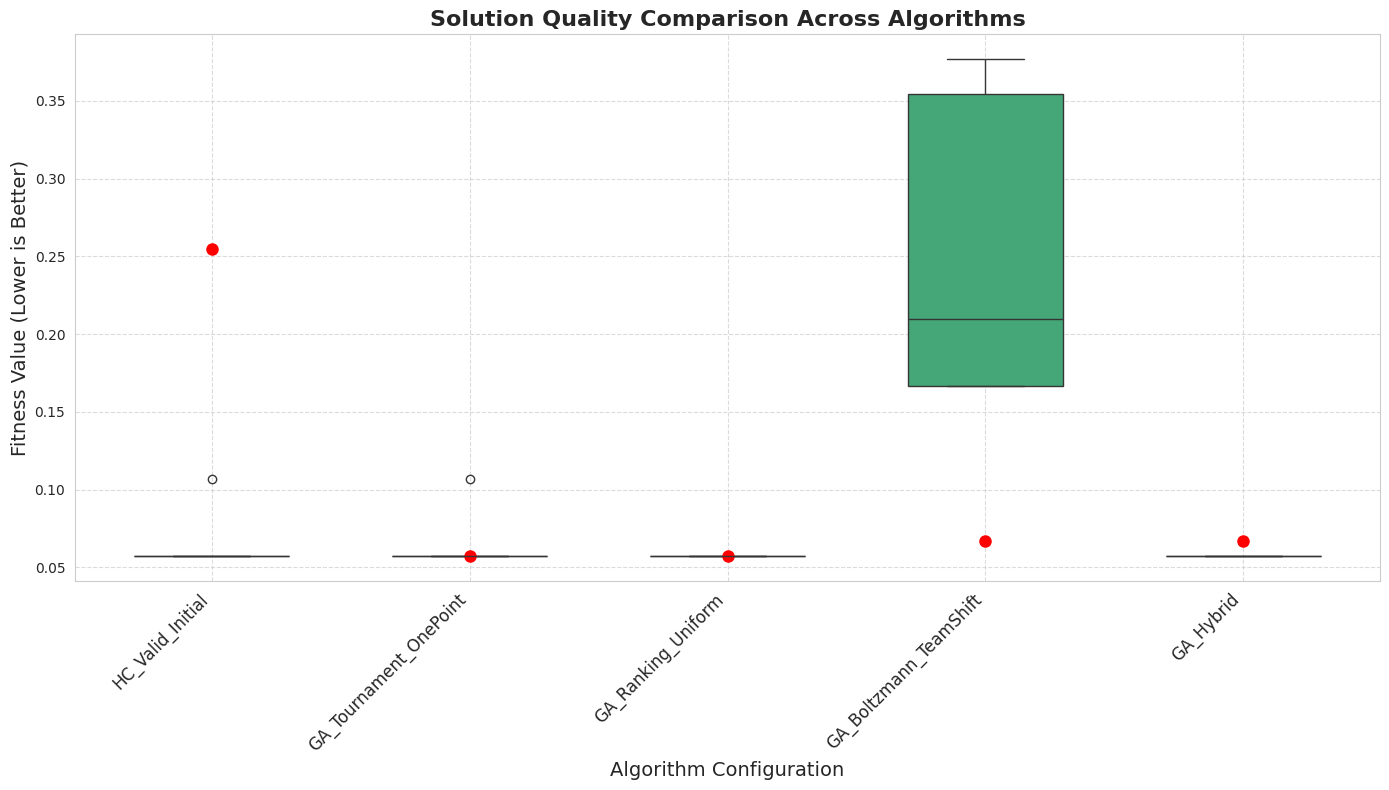

Fitness Statistics (Lower is Better):
                            mean       std       min       max
Configuration                                                 
GA_Boltzmann_TeamShift  0.254920  0.102989  0.166599  0.376883
GA_Hybrid               0.057143  0.000000  0.057143  0.057143
GA_Ranking_Uniform      0.057143  0.000000  0.057143  0.057143
GA_Tournament_OnePoint  0.067095  0.022254  0.057143  0.106904
HC_Standard                  inf       nan       inf       inf
HC_Valid_Initial        0.067095  0.022254  0.057143  0.106904
SA_Standard                  inf       nan       inf       inf


In [7]:
# Compare solution quality (fitness values)
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.boxplot(x='Configuration', y='Fitness', 
                data=results_df[results_df['Fitness'] < float('inf')],
                palette='viridis', width=0.6)
plt.title('Solution Quality Comparison Across Algorithms', fontsize=16, fontweight='bold')
plt.xlabel('Algorithm Configuration', fontsize=14)
plt.ylabel('Fitness Value (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add mean markers
means = results_df[results_df['Fitness'] < float('inf')].groupby('Configuration')['Fitness'].mean()
for i, mean_val in enumerate(means):
    ax.plot(i, mean_val, marker='o', color='red', markersize=8)

plt.tight_layout()
plt.show()

# Display summary statistics with improved formatting
fitness_stats = results_df.groupby('Configuration')['Fitness'].agg(['mean', 'std', 'min', 'max'])
print("Fitness Statistics (Lower is Better):")
print("=" * 80)
formatted_stats = fitness_stats.copy()
for col in formatted_stats.columns:
    formatted_stats[col] = formatted_stats[col].apply(lambda x: f"{x:.6f}")
print(formatted_stats)

### 4.2 Computational Efficiency Comparison

/tmp/ipykernel_379114/2079288650.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Configuration', y='Runtime', data=results_df,


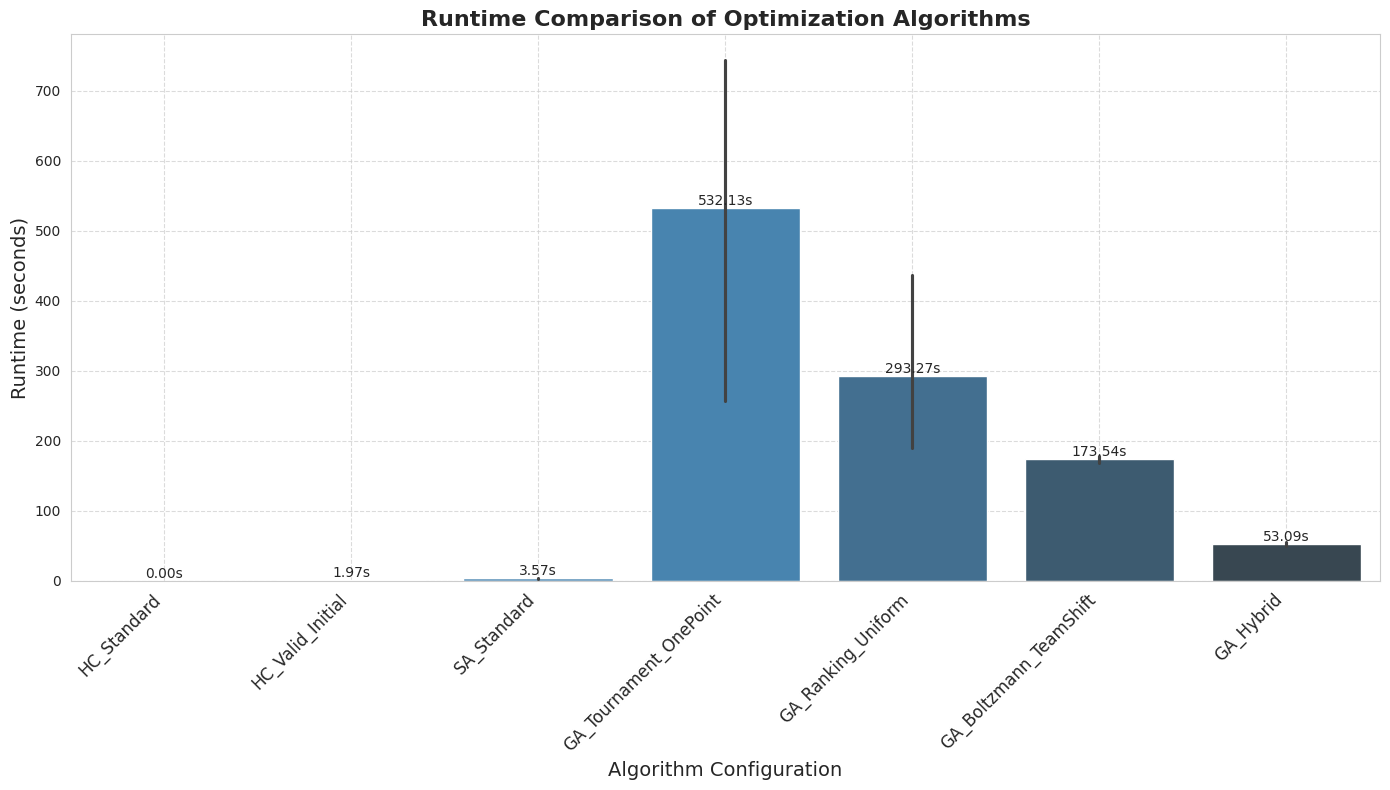

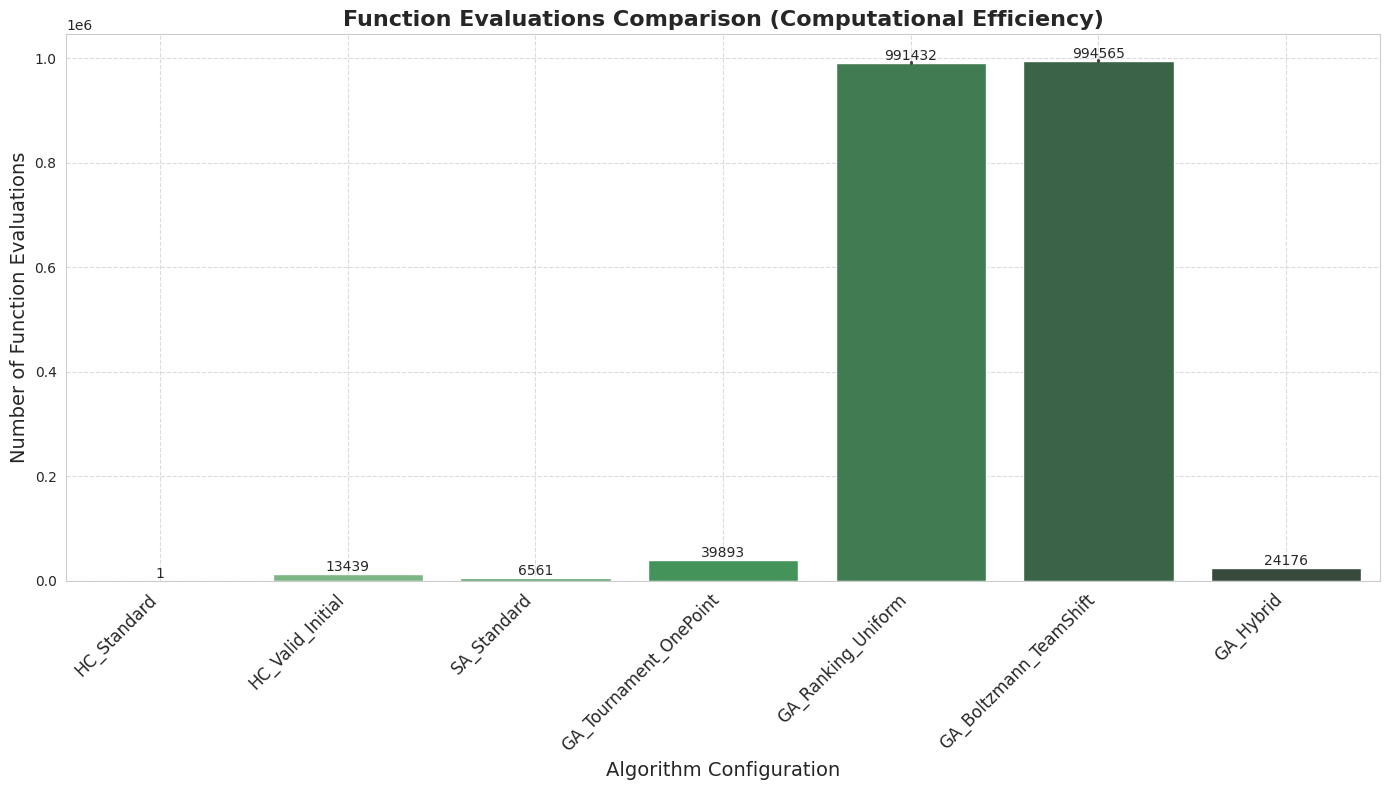

In [8]:
# Compare runtime
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.barplot(x='Configuration', y='Runtime', data=results_df, 
                palette='Blues_d', errorbar=('ci', 95))
plt.title('Runtime Comparison of Optimization Algorithms', fontsize=16, fontweight='bold')
plt.xlabel('Algorithm Configuration', fontsize=14)
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.2f}s', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, rotation=0)

plt.tight_layout()
plt.show()

# Compare function evaluations
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.barplot(x='Configuration', y='Evaluations', hue='Configuration', data=results_df,
                palette='Greens_d', errorbar=('ci', 95), legend=False)
plt.title('Function Evaluations Comparison (Computational Efficiency)', fontsize=16, fontweight='bold')
plt.xlabel('Algorithm Configuration', fontsize=14)
plt.ylabel('Number of Function Evaluations', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, rotation=0)

plt.tight_layout()
plt.show()

### 4.3 Convergence Analysis

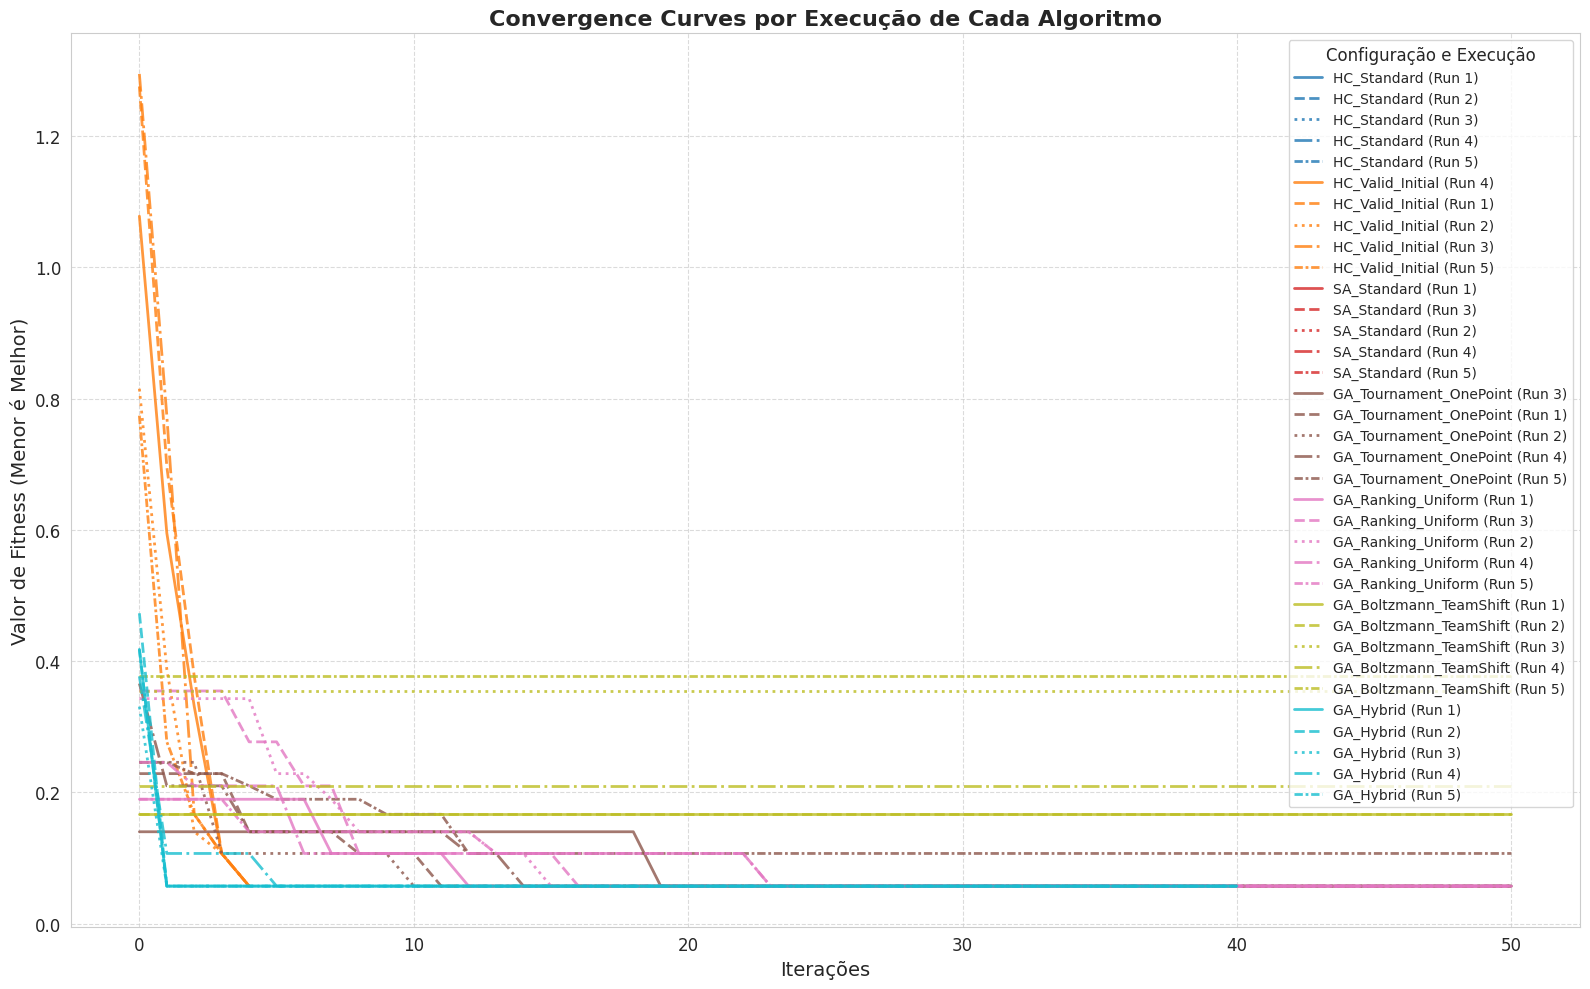

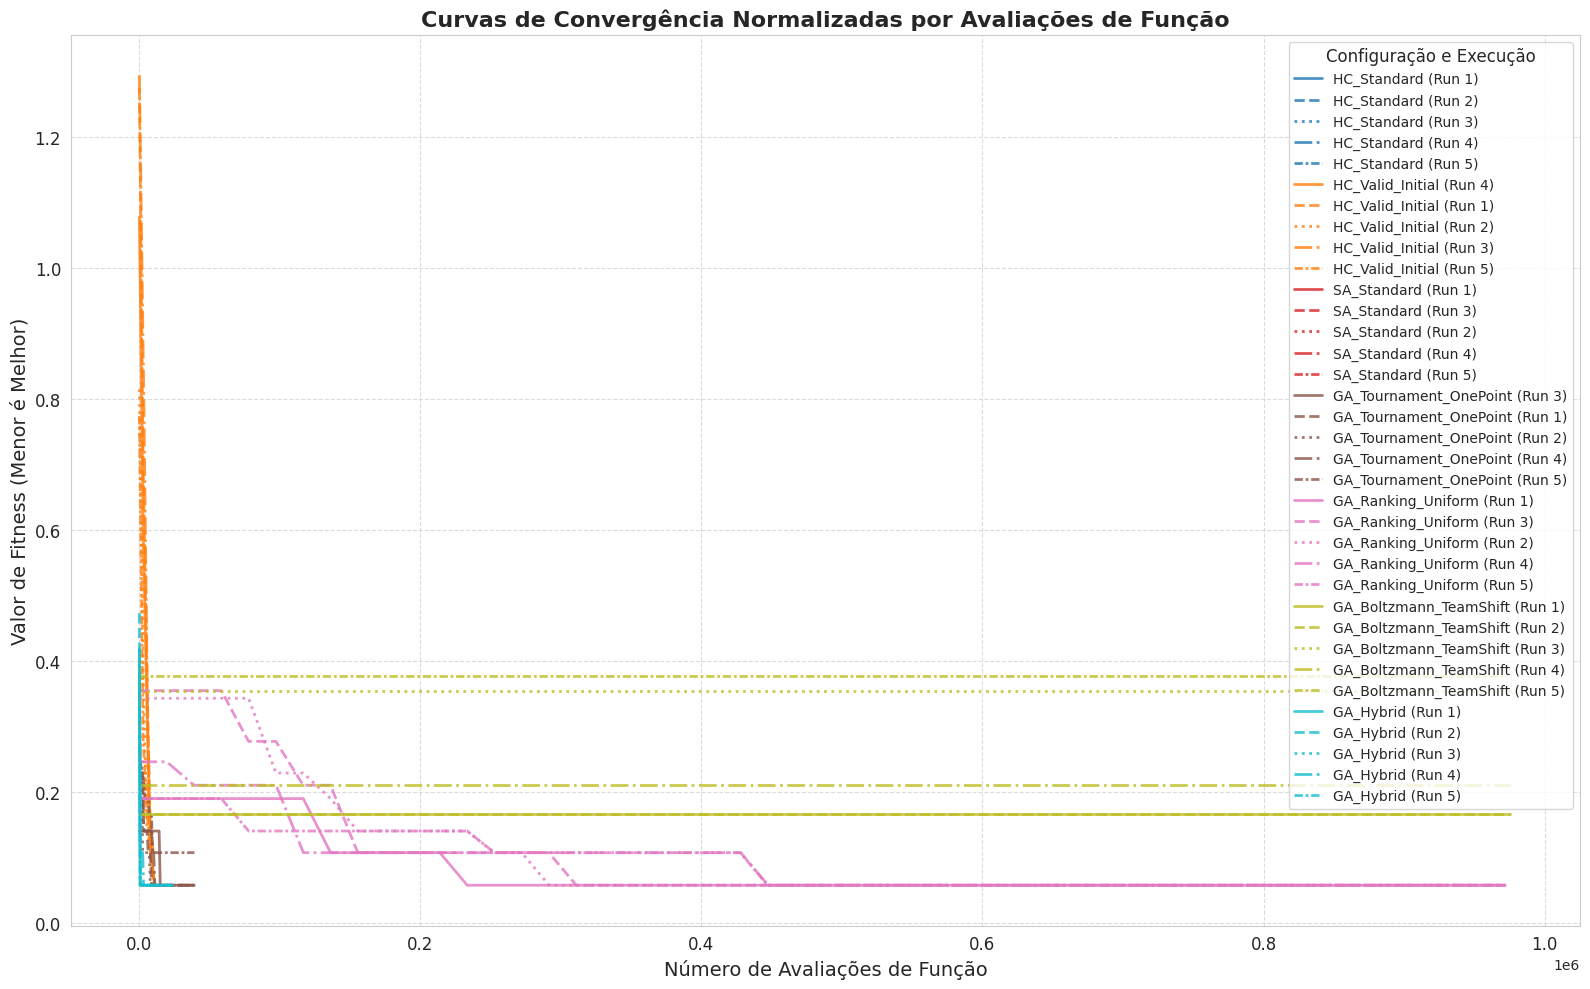

In [9]:
# Plot convergence curves for each algorithm and each run
plt.figure(figsize=(16, 10))

# Use a consistent color palette for configurations
config_colors = plt.cm.tab10(np.linspace(0, 1, len(configs)))
config_color_map = {config: config_colors[i] for i, config in enumerate(configs.keys())}

# Line styles for different runs
line_styles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]

# Plot each configuration and run
for config_name in configs.keys():
    # Get all runs for this configuration
    config_runs = results_df[(results_df['Configuration'] == config_name)]
    
    if len(config_runs) > 0 and 'History' in config_runs.columns:
        # Plot each run separately
        for i, (_, run_data) in enumerate(config_runs.iterrows()):
            if isinstance(run_data['History'], list) and len(run_data['History']) > 0:
                run_num = run_data['Run']
                line_style = line_styles[i % len(line_styles)]
                
                # Plot the convergence curve with consistent color by config and line style by run
                plt.plot(run_data['History'], 
                         label=f"{config_name} (Run {run_num})", 
                         color=config_color_map[config_name],
                         linestyle=line_style,
                         linewidth=2,
                         alpha=0.8)

plt.title('Convergence Curves por Execução de Cada Algoritmo', fontsize=16, fontweight='bold')
plt.xlabel('Iterações', fontsize=14)
plt.ylabel('Valor de Fitness (Menor é Melhor)', fontsize=14)
plt.legend(title='Configuração e Execução', fontsize=10, title_fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

# Plot normalized convergence curves (by function evaluations) for each run
plt.figure(figsize=(16, 10))

# Use a consistent color palette for configurations
config_colors = plt.cm.tab10(np.linspace(0, 1, len(configs)))
config_color_map = {config: config_colors[i] for i, config in enumerate(configs.keys())}

# Line styles for different runs
line_styles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]

# Plot each configuration and run
for config_name in configs.keys():
    # Get all runs for this configuration
    config_runs = results_df[(results_df['Configuration'] == config_name)]
    
    if len(config_runs) > 0 and 'History' in config_runs.columns:
        # Plot each run separately
        for i, (_, run_data) in enumerate(config_runs.iterrows()):
            if isinstance(run_data['History'], list) and len(run_data['History']) > 0:
                run_num = run_data['Run']
                line_style = line_styles[i % len(line_styles)]
                
                # Calculate evaluations per iteration (approximately)
                evals_per_iter = run_data['Evaluations'] / len(run_data['History'])
                
                # Create x-axis values representing function evaluations
                x_values = [i * evals_per_iter for i in range(len(run_data['History']))]
                
                # Plot the normalized convergence curve
                plt.plot(x_values, run_data['History'], 
                         label=f"{config_name} (Run {run_num})",
                         color=config_color_map[config_name],
                         linestyle=line_style,
                         linewidth=2,
                         alpha=0.8)

plt.title('Curvas de Convergência Normalizadas por Avaliações de Função', fontsize=16, fontweight='bold')
plt.xlabel('Número de Avaliações de Função', fontsize=14)
plt.ylabel('Valor de Fitness (Menor é Melhor)', fontsize=14)
plt.legend(title='Configuração e Execução', fontsize=10, title_fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

### 4.4 Comparação de Algoritmos Genéticos por Execução

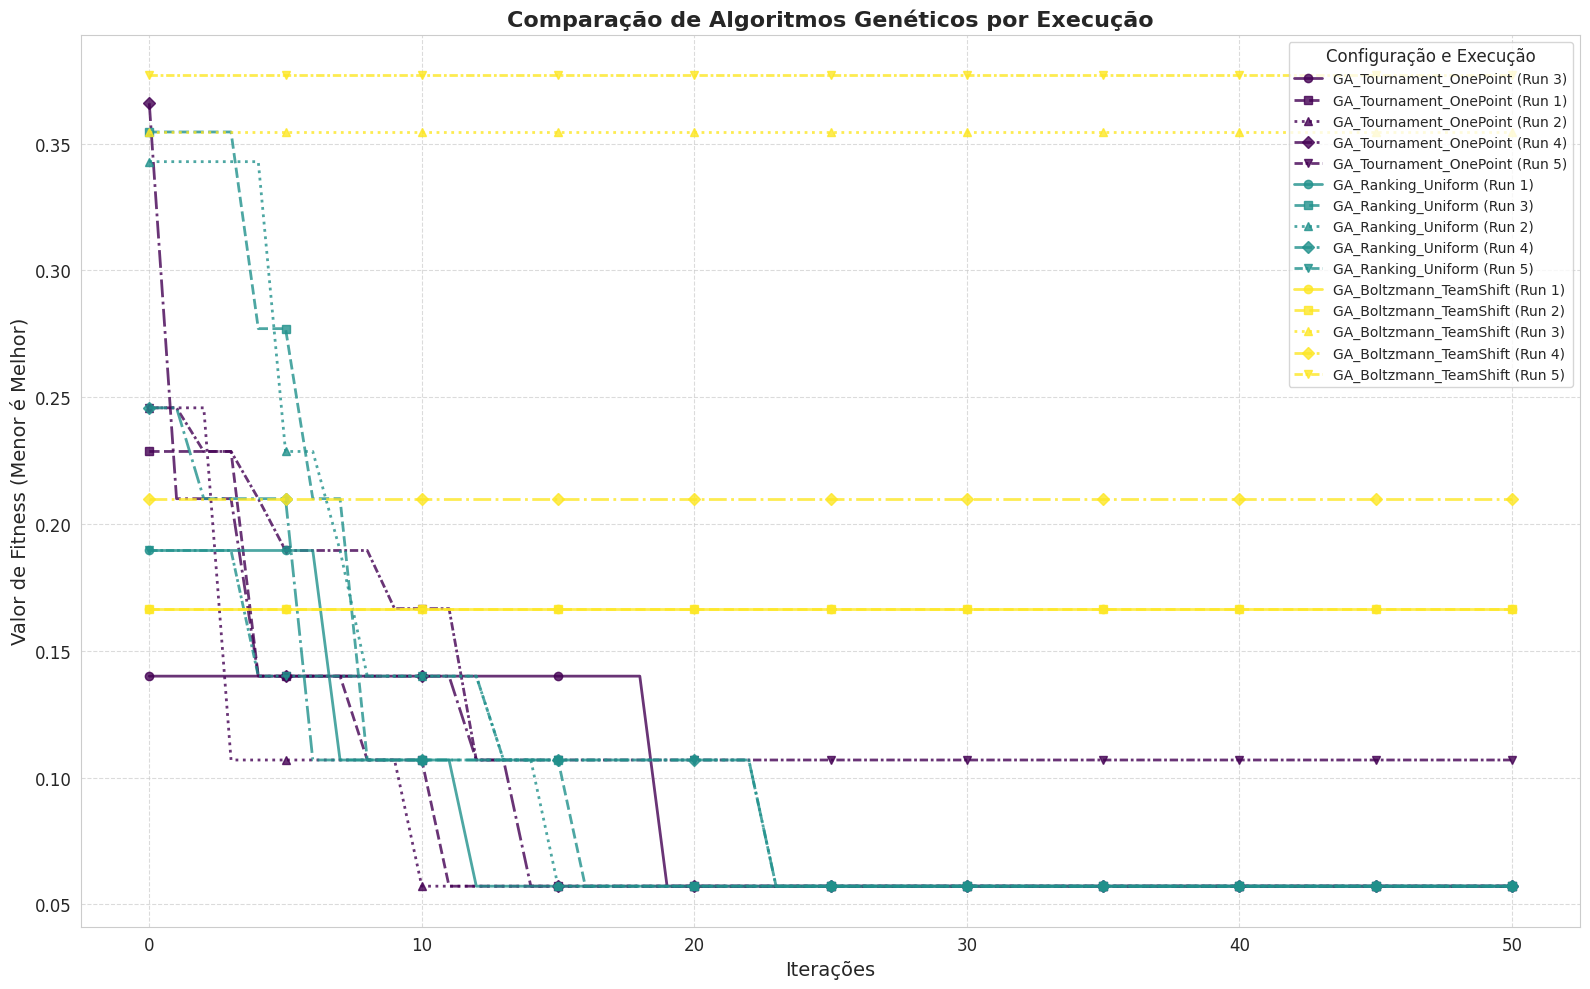

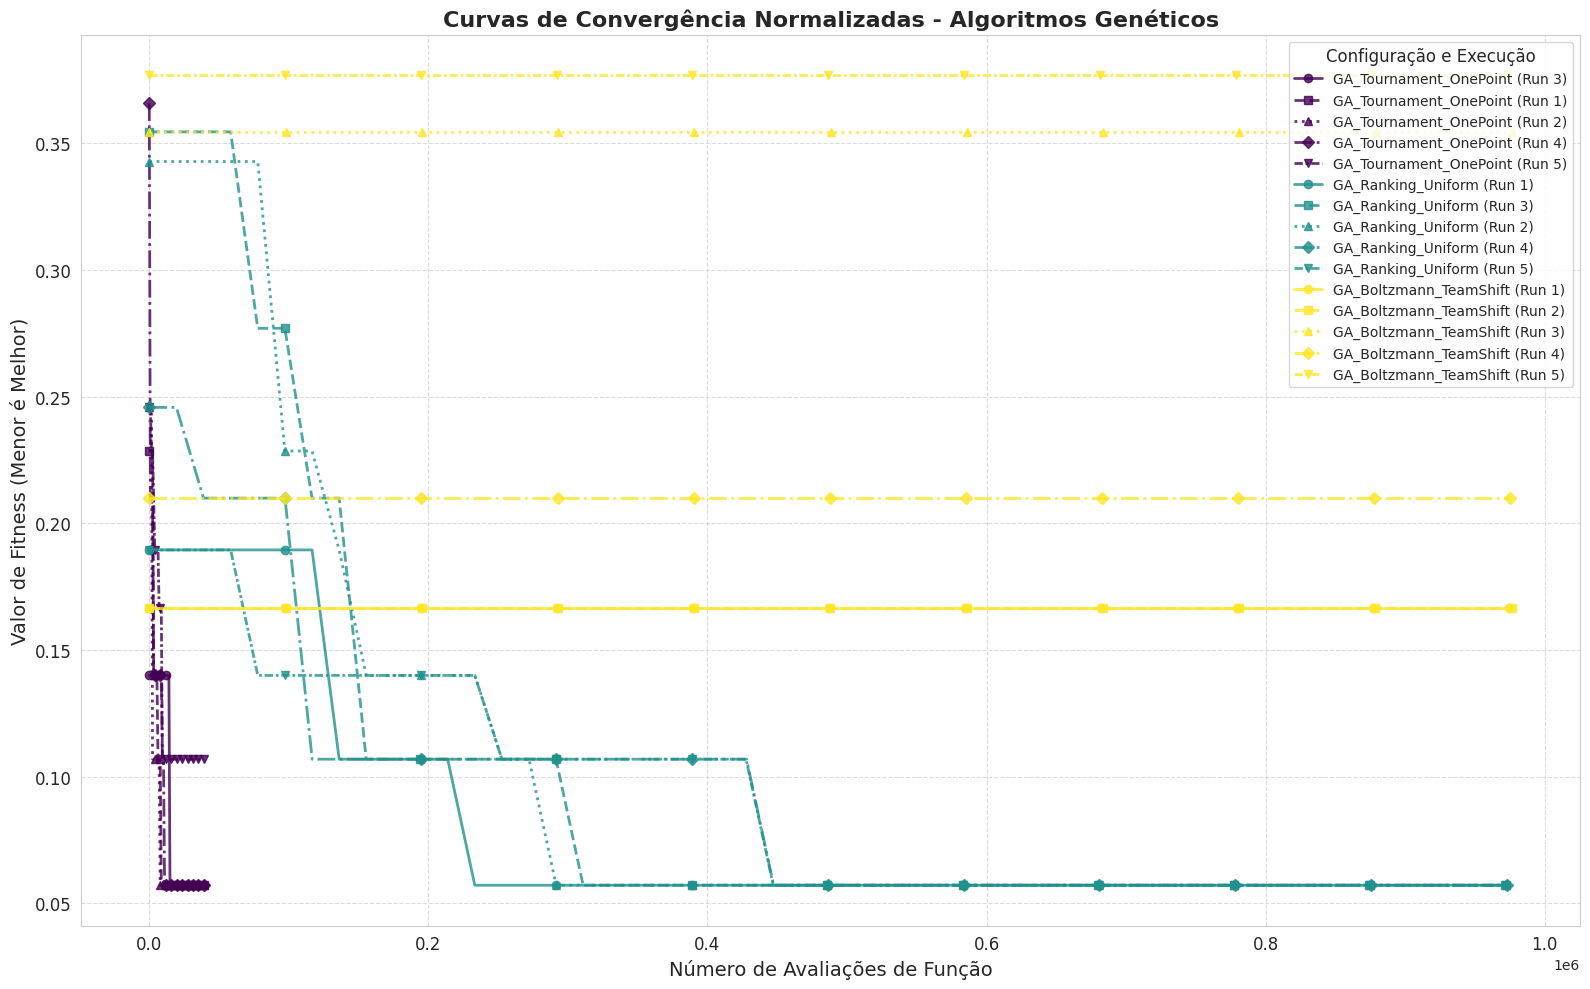

In [10]:
# Plot convergence curves for GA algorithms only, comparing all runs
plt.figure(figsize=(16, 10))

# Filter only GA configurations
ga_configs = {k: v for k, v in configs.items() if 'Genetic Algorithm' in v['algorithm']}

# Use a consistent color palette for configurations
ga_colors = plt.cm.viridis(np.linspace(0, 1, len(ga_configs)))
ga_color_map = {config: ga_colors[i] for i, config in enumerate(ga_configs.keys())}

# Line styles for different runs
line_styles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'v']

# Plot each GA configuration and run
for config_name in ga_configs.keys():
    # Get all runs for this configuration
    config_runs = results_df[(results_df['Configuration'] == config_name)]
    
    if len(config_runs) > 0 and 'History' in config_runs.columns:
        # Plot each run separately
        for i, (_, run_data) in enumerate(config_runs.iterrows()):
            if isinstance(run_data['History'], list) and len(run_data['History']) > 0:
                run_num = run_data['Run']
                line_style = line_styles[i % len(line_styles)]
                marker = markers[i % len(markers)]
                
                # Plot with markers at regular intervals for better visibility
                plt.plot(run_data['History'], 
                         label=f"{config_name} (Run {run_num})", 
                         color=ga_color_map[config_name],
                         linestyle=line_style,
                         marker=marker,
                         markevery=max(1, len(run_data['History'])//10),  # Show markers at regular intervals
                         markersize=6,
                         linewidth=2,
                         alpha=0.8)

plt.title('Comparação de Algoritmos Genéticos por Execução', fontsize=16, fontweight='bold')
plt.xlabel('Iterações', fontsize=14)
plt.ylabel('Valor de Fitness (Menor é Melhor)', fontsize=14)
plt.legend(title='Configuração e Execução', fontsize=10, title_fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

# Plot normalized convergence curves for GA algorithms only
plt.figure(figsize=(16, 10))

# Plot each GA configuration and run with normalized x-axis
for config_name in ga_configs.keys():
    # Get all runs for this configuration
    config_runs = results_df[(results_df['Configuration'] == config_name)]
    
    if len(config_runs) > 0 and 'History' in config_runs.columns:
        # Plot each run separately
        for i, (_, run_data) in enumerate(config_runs.iterrows()):
            if isinstance(run_data['History'], list) and len(run_data['History']) > 0:
                run_num = run_data['Run']
                line_style = line_styles[i % len(line_styles)]
                marker = markers[i % len(markers)]
                
                # Calculate evaluations per iteration (approximately)
                evals_per_iter = run_data['Evaluations'] / len(run_data['History'])
                
                # Create x-axis values representing function evaluations
                x_values = [i * evals_per_iter for i in range(len(run_data['History']))]
                
                # Plot the normalized convergence curve
                plt.plot(x_values, run_data['History'], 
                         label=f"{config_name} (Run {run_num})",
                         color=ga_color_map[config_name],
                         linestyle=line_style,
                         marker=marker,
                         markevery=max(1, len(run_data['History'])//10),
                         markersize=6,
                         linewidth=2,
                         alpha=0.8)

plt.title('Curvas de Convergência Normalizadas - Algoritmos Genéticos', fontsize=16, fontweight='bold')
plt.xlabel('Número de Avaliações de Função', fontsize=14)
plt.ylabel('Valor de Fitness (Menor é Melhor)', fontsize=14)
plt.legend(title='Configuração e Execução', fontsize=10, title_fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

### 4.5 Comparação Empilhada de Algoritmos Genéticos por Geração

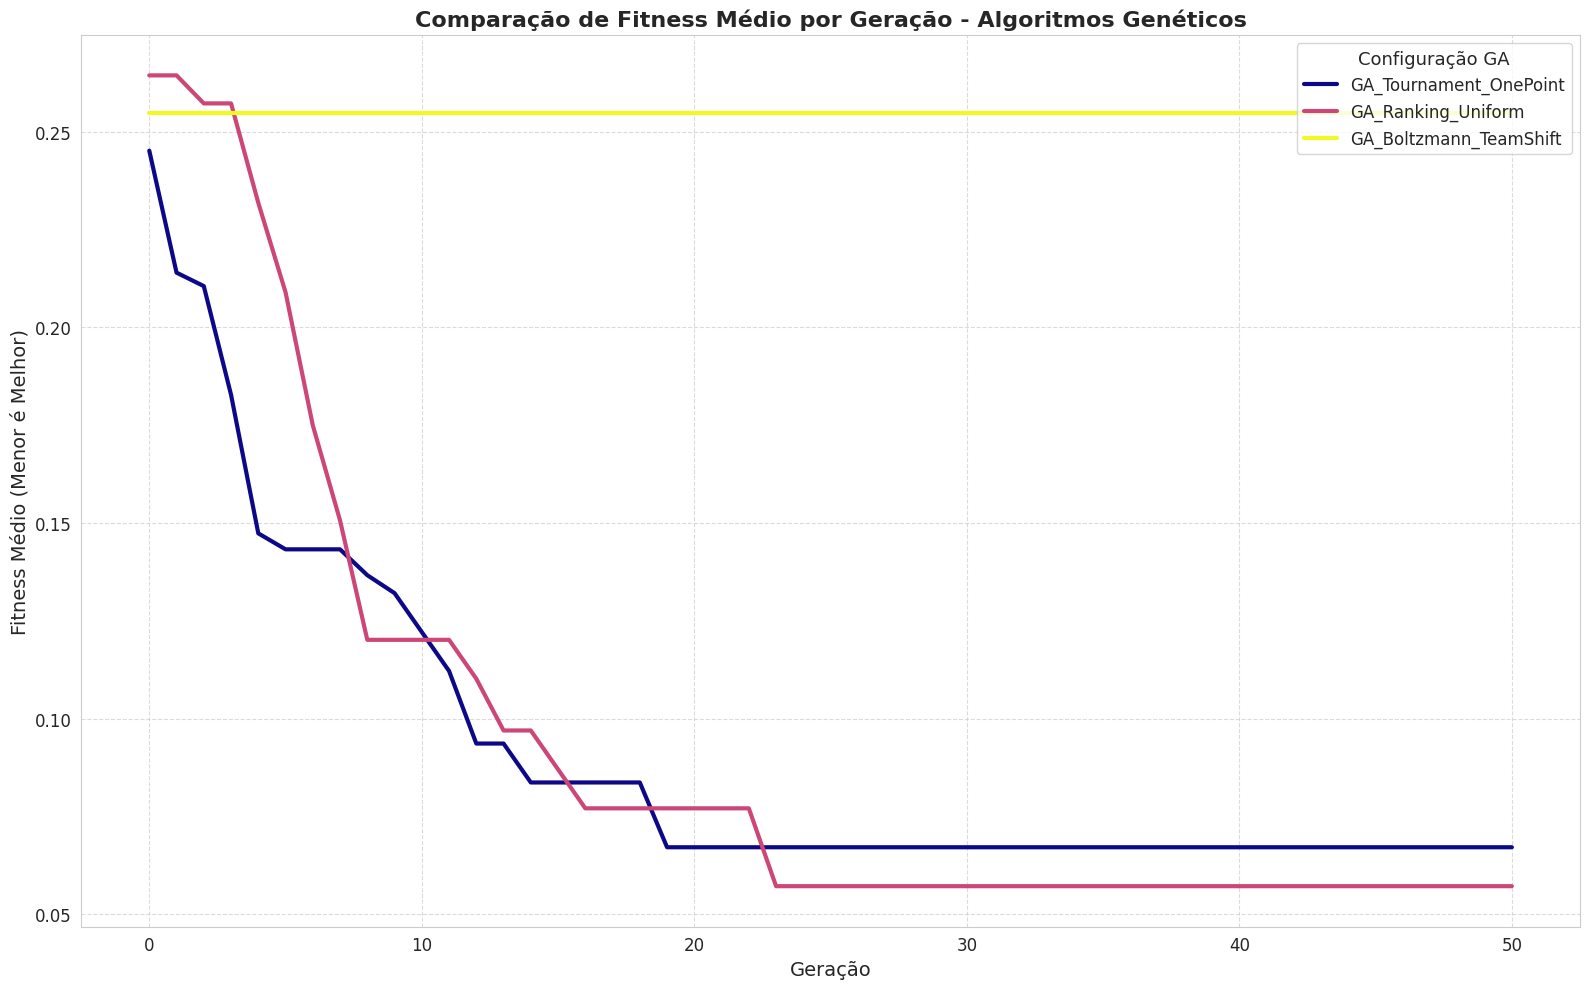

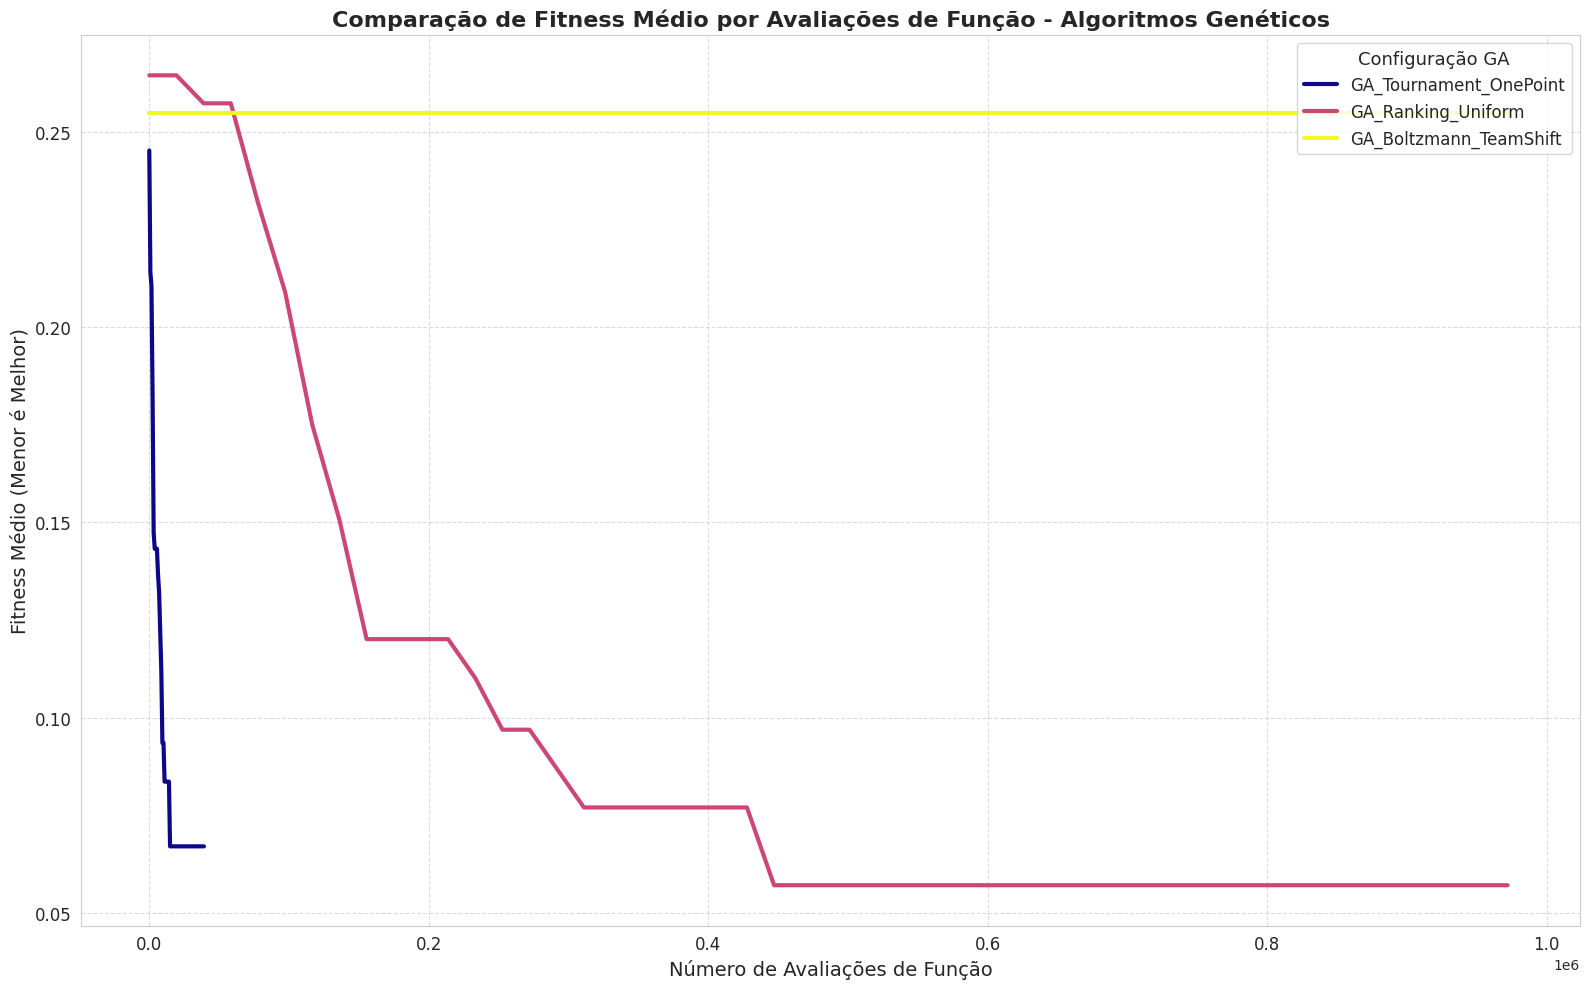

In [11]:
# Create a stacked comparison of GA algorithms showing average fitness by generation
plt.figure(figsize=(16, 10))

# Filter only GA configurations
ga_configs = {k: v for k, v in configs.items() if 'Genetic Algorithm' in v['algorithm']}

# Use a consistent color palette for configurations
ga_colors = plt.cm.plasma(np.linspace(0, 1, len(ga_configs)))
ga_color_map = {config: ga_colors[i] for i, config in enumerate(ga_configs.keys())}

# Find the maximum number of generations across all GA runs
max_generations = 0
for config_name in ga_configs.keys():
    config_runs = results_df[(results_df['Configuration'] == config_name)]
    for _, run_data in config_runs.iterrows():
        if isinstance(run_data['History'], list) and len(run_data['History']) > max_generations:
            max_generations = len(run_data['History'])

# Prepare data structure to hold average fitness by generation for each GA type
ga_avg_fitness = {}
for config_name in ga_configs.keys():
    ga_avg_fitness[config_name] = np.zeros(max_generations)
    count = np.zeros(max_generations)
    
    # Get all runs for this configuration
    config_runs = results_df[(results_df['Configuration'] == config_name)]
    
    # Accumulate fitness values for each generation
    for _, run_data in config_runs.iterrows():
        if isinstance(run_data['History'], list) and len(run_data['History']) > 0:
            history = run_data['History']
            for i, fitness in enumerate(history):
                if i < max_generations:
                    ga_avg_fitness[config_name][i] += fitness
                    count[i] += 1
    
    # Calculate average, avoiding division by zero
    for i in range(max_generations):
        if count[i] > 0:
            ga_avg_fitness[config_name][i] /= count[i]
        else:
            # If no data for this generation, use the last known value or infinity
            if i > 0 and count[i-1] > 0:
                ga_avg_fitness[config_name][i] = ga_avg_fitness[config_name][i-1]
            else:
                ga_avg_fitness[config_name][i] = float('inf')

# Plot average fitness by generation for each GA type
for config_name, avg_fitness in ga_avg_fitness.items():
    plt.plot(range(max_generations), avg_fitness, 
             label=config_name,
             color=ga_color_map[config_name],
             linewidth=3)

plt.title('Comparação de Fitness Médio por Geração - Algoritmos Genéticos', fontsize=16, fontweight='bold')
plt.xlabel('Geração', fontsize=14)
plt.ylabel('Fitness Médio (Menor é Melhor)', fontsize=14)
plt.legend(title='Configuração GA', fontsize=12, title_fontsize=13, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

# Plot normalized by function evaluations
plt.figure(figsize=(16, 10))

# Calculate average evaluations per generation for each GA type
ga_avg_evals_per_gen = {}
for config_name in ga_configs.keys():
    config_runs = results_df[(results_df['Configuration'] == config_name)]
    total_evals = 0
    total_gens = 0
    
    for _, run_data in config_runs.iterrows():
        if isinstance(run_data['History'], list) and len(run_data['History']) > 0:
            total_evals += run_data['Evaluations']
            total_gens += len(run_data['History'])
    
    if total_gens > 0:
        ga_avg_evals_per_gen[config_name] = total_evals / total_gens
    else:
        ga_avg_evals_per_gen[config_name] = 1  # Default if no data

# Plot average fitness by function evaluations for each GA type
for config_name, avg_fitness in ga_avg_fitness.items():
    # Create x-axis values representing function evaluations
    evals_per_gen = ga_avg_evals_per_gen[config_name]
    x_values = [i * evals_per_gen for i in range(len(avg_fitness))]
    
    plt.plot(x_values, avg_fitness, 
             label=config_name,
             color=ga_color_map[config_name],
             linewidth=3)

plt.title('Comparação de Fitness Médio por Avaliações de Função - Algoritmos Genéticos', fontsize=16, fontweight='bold')
plt.xlabel('Número de Avaliações de Função', fontsize=14)
plt.ylabel('Fitness Médio (Menor é Melhor)', fontsize=14)
plt.legend(title='Configuração GA', fontsize=12, title_fontsize=13, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

## 5. Statistical Analysis

Let's perform statistical tests to determine if there are significant differences between algorithms.


=== Multiple-Group Comparison ===
Shapiro-Wilk normality test p-value for HC_Valid_Initial: 0.0001
Shapiro-Wilk normality test p-value for GA_Tournament_OnePoint: 0.0001
Shapiro-Wilk normality test p-value for GA_Ranking_Uniform: 1.0000
Shapiro-Wilk normality test p-value for GA_Boltzmann_TeamShift: 0.0937
Shapiro-Wilk normality test p-value for GA_Hybrid: 1.0000
Data does not appear normally distributed, using Kruskal-Wallis test
Kruskal-Wallis test p-value: 0.0008
Effect size (Eta-squared (H)): 0.7497 (Large)
Significant difference: True

=== Post-hoc Tests ===
Error performing Dunn's test: cannot unpack non-iterable NoneType object
Falling back to pairwise Mann-Whitney U tests with Bonferroni correction
HC_Valid_Initial vs GA_Tournament_OnePoint: p-value = 1.0000
HC_Valid_Initial vs GA_Ranking_Uniform: p-value = 0.4237
HC_Valid_Initial vs GA_Boltzmann_TeamShift: p-value = 0.0097
HC_Valid_Initial vs GA_Hybrid: p-value = 0.4237
GA_Tournament_OnePoint vs GA_Ranking_Uniform: p-value = 

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipykernel_379114/2757747959.py:317: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Configuration', y='Fitness', data=valid_results,


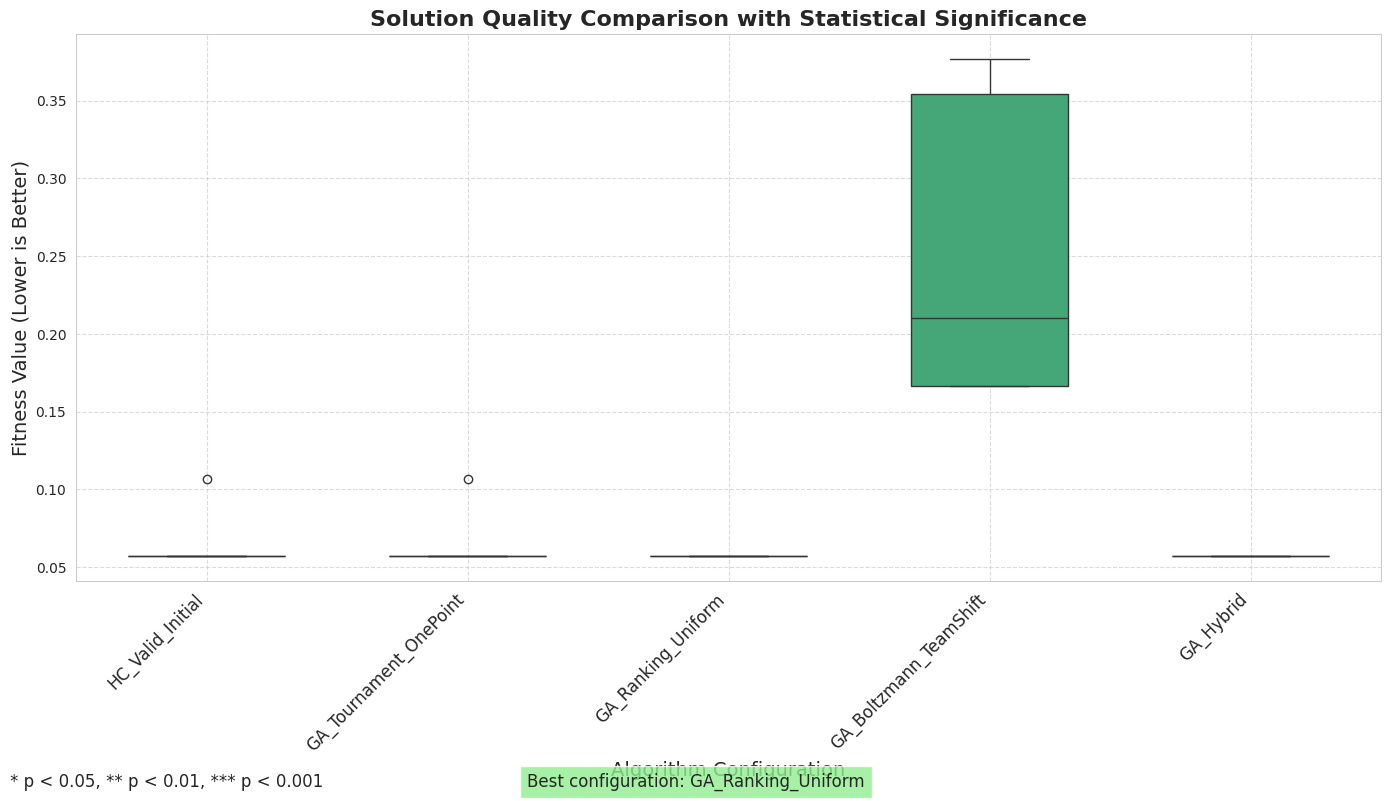

In [12]:
# Function to perform statistical analysis
def perform_statistical_analysis(results_df):
    """
    Perform statistical analysis on experiment results.
    
    Args:
        results_df: DataFrame with experiment results
        
    Returns:
        Dictionary with statistical analysis results
    """
    # Filter out invalid results (inf fitness)
    valid_results = results_df[results_df['Fitness'] < float('inf')]
    
    # Get unique configurations
    configurations = valid_results['Configuration'].unique()
    
    # If we have only one configuration, no comparison needed
    if len(configurations) <= 1:
        print("Not enough valid configurations for statistical comparison")
        return None
    elif len(configurations) == 2:
        print("\n=== Two-Group Comparison ===")
        return two_group_comparison(valid_results, configurations)
    else:
        print("\n=== Multiple-Group Comparison ===")
        return multiple_group_comparison(valid_results, configurations)

# Function to perform two-group comparison
def two_group_comparison(results_df, configurations):
    """
    Perform statistical comparison between two groups.
    
    Args:
        results_df: DataFrame with experiment results
        configurations: List of two configurations to compare
        
    Returns:
        Dictionary with statistical analysis results
    """
    # Extract data for each configuration
    group1 = results_df[results_df['Configuration'] == configurations[0]]['Fitness']
    group2 = results_df[results_df['Configuration'] == configurations[1]]['Fitness']
    
    # Check for normality using Shapiro-Wilk test
    _, p_norm1 = stats.shapiro(group1)
    _, p_norm2 = stats.shapiro(group2)
    
    print(f"Shapiro-Wilk normality test p-values: {configurations[0]}: {p_norm1:.4f}, {configurations[1]}: {p_norm2:.4f}")
    
    # Determine if data is normally distributed
    alpha = 0.05
    is_normal = (p_norm1 > alpha) and (p_norm2 > alpha)
    
    if is_normal:
        # Use t-test for normally distributed data
        print("Data appears normally distributed, using t-test")
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        test_name = "Welch's t-test"
        
        # Calculate effect size (Cohen's d)
        mean1, mean2 = group1.mean(), group2.mean()
        std1, std2 = group1.std(), group2.std()
        pooled_std = np.sqrt(((len(group1) - 1) * std1**2 + (len(group2) - 1) * std2**2) / 
                             (len(group1) + len(group2) - 2))
        effect_size = abs(mean1 - mean2) / pooled_std
        effect_size_name = "Cohen's d"
        
    else:
        # Use Mann-Whitney U test for non-normally distributed data
        print("Data does not appear normally distributed, using Mann-Whitney U test")
        u_stat, p_value = stats.mannwhitneyu(group1, group2)
        test_name = "Mann-Whitney U test"
        
        # Calculate effect size (r = Z / sqrt(N))
        n1, n2 = len(group1), len(group2)
        z_score = stats.norm.ppf(1 - p_value/2)  # Two-tailed p-value to z-score
        effect_size = abs(z_score) / np.sqrt(n1 + n2)
        effect_size_name = "r (rank-biserial correlation)"
    
    # Interpret effect size
    if effect_size < 0.2:
        effect_interpretation = "Small"
    elif effect_size < 0.5:
        effect_interpretation = "Medium"
    elif effect_size < 0.8:
        effect_interpretation = "Large"
    else:
        effect_interpretation = "Very Large"
    
    # Determine significance
    is_significant = p_value < alpha
    
    print(f"{test_name} p-value: {p_value:.4f}")
    print(f"Effect size ({effect_size_name}): {effect_size:.4f} ({effect_interpretation})")
    print(f"Significant difference: {is_significant}")
    
    # Return results
    return {
        'test_name': test_name,
        'p_value': p_value,
        'effect_size': effect_size,
        'effect_size_name': effect_size_name,
        'effect_interpretation': effect_interpretation,
        'is_significant': is_significant,
        'better_configuration': configurations[0] if group1.mean() < group2.mean() else configurations[1]
    }

# Function to perform multiple-group comparison
def multiple_group_comparison(results_df, configurations):
    """
    Perform statistical comparison between multiple groups.
    
    Args:
        results_df: DataFrame with experiment results
        configurations: List of configurations to compare
        
    Returns:
        Dictionary with statistical analysis results
    """
    # Check if we have enough data for each configuration
    groups = []
    valid_configs = []
    for config in configurations:
        group = results_df[results_df['Configuration'] == config]['Fitness']
        if len(group) >= 3:  # Need at least 3 samples for statistical tests
            groups.append(group)
            valid_configs.append(config)
        else:
            print(f"Warning: Configuration {config} has fewer than 3 valid results, excluding from analysis")
    
    if len(groups) < 2:
        print("Not enough valid configurations with sufficient data for statistical comparison")
        return None
    
    # Check for normality using Shapiro-Wilk test
    normal_data = True
    for i, config in enumerate(valid_configs):
        if i < len(groups):
            # Handle potential errors in Shapiro-Wilk test
            try:
                _, p_norm = stats.shapiro(groups[i])
                print(f"Shapiro-Wilk normality test p-value for {config}: {p_norm:.4f}")
                if p_norm <= 0.05:
                    normal_data = False
            except Exception as e:
                print(f"Error in normality test for {config}: {str(e)}")
                normal_data = False  # Assume non-normal if test fails
    
    # Determine which test to use based on normality
    alpha = 0.05
    if normal_data:
        # Use one-way ANOVA for normally distributed data
        print("Data appears normally distributed, using one-way ANOVA")
        try:
            f_stat, p_value = stats.f_oneway(*groups)
            test_name = "One-way ANOVA"
            
            # Calculate effect size (Eta-squared)
            # Convert groups to a single array and create a group label array
            all_data = np.concatenate(groups)
            group_labels = np.concatenate([[i] * len(group) for i, group in enumerate(groups)])
            
            # Calculate grand mean and group means
            grand_mean = np.mean(all_data)
            group_means = [np.mean(group) for group in groups]
        except Exception as e:
            print(f"Error in ANOVA test: {str(e)}")
            print("Falling back to non-parametric Kruskal-Wallis test")
            normal_data = False  # Fall back to non-parametric test
        
        # Calculate sum of squares
        ss_total = np.sum((all_data - grand_mean) ** 2)
        ss_between = np.sum([len(group) * (mean - grand_mean) ** 2 for group, mean in zip(groups, group_means)])
        
        # Calculate Eta-squared
        effect_size = ss_between / ss_total
        effect_size_name = "Eta-squared"
        
    else:
        # Use Kruskal-Wallis test for non-normally distributed data
        print("Data does not appear normally distributed, using Kruskal-Wallis test")
        h_stat, p_value = stats.kruskal(*groups)
        test_name = "Kruskal-Wallis test"
        
        # Calculate effect size (Eta-squared for Kruskal-Wallis)
        # This is an approximation based on the H statistic
        n_total = sum(len(group) for group in groups)
        effect_size = (h_stat - len(groups) + 1) / (n_total - len(groups))
        effect_size_name = "Eta-squared (H)"
    
    # Interpret effect size
    if effect_size < 0.01:
        effect_interpretation = "Very Small"
    elif effect_size < 0.06:
        effect_interpretation = "Small"
    elif effect_size < 0.14:
        effect_interpretation = "Medium"
    else:
        effect_interpretation = "Large"
    
    # Determine significance
    is_significant = p_value < alpha
    
    print(f"{test_name} p-value: {p_value:.4f}")
    print(f"Effect size ({effect_size_name}): {effect_size:.4f} ({effect_interpretation})")
    print(f"Significant difference: {is_significant}")
    
    # If significant, perform post-hoc tests
    significant_pairs = []
    if is_significant:
        print("\n=== Post-hoc Tests ===")
        
        if normal_data:
            # Use Tukey HSD for normally distributed data
            from statsmodels.stats.multicomp import pairwise_tukeyhsd
            
            # Prepare data for Tukey HSD
            all_data = np.concatenate(groups)
            group_labels = np.concatenate([[str(configurations[i])] * len(group) for i, group in enumerate(groups) if i < len(configurations)])
            
            # Perform Tukey HSD test
            tukey_results = pairwise_tukeyhsd(all_data, group_labels, alpha=alpha)
            print(tukey_results)
            
            # Extract significant pairs
            for i in range(len(tukey_results.reject)):
                if tukey_results.reject[i]:
                    pair = (tukey_results.groupsunique[tukey_results.data[i, 0]], 
                            tukey_results.groupsunique[tukey_results.data[i, 1]])
                    significant_pairs.append(pair)
            
            post_hoc_name = "Tukey HSD"
            
        else:
            # Use Dunn's test with Bonferroni correction for non-normally distributed data
            try:
                # Prepare data for Dunn's test using scikit-posthocs
                dunn_data = {}
                for i, config in enumerate(configurations):
                    if i < len(groups):
                        dunn_data[config] = groups[i]
                
                # Perform Dunn's test
                dunn_results = sp.posthoc_dunn(dunn_data, p_adjust='bonferroni')
                print(dunn_results)
                
                # Extract significant pairs
                for i in range(len(dunn_results.columns)):
                    for j in range(i+1, len(dunn_results.columns)):
                        if dunn_results.iloc[i, j] < alpha:
                            pair = (dunn_results.columns[i], dunn_results.columns[j])
                            significant_pairs.append(pair)
                
                post_hoc_name = "Dunn's test with Bonferroni correction"
            except Exception as e:
                print(f"Error performing Dunn's test: {str(e)}")
                print("Falling back to pairwise Mann-Whitney U tests with Bonferroni correction")
                
                # Perform pairwise Mann-Whitney U tests with Bonferroni correction
                num_comparisons = len(groups) * (len(groups) - 1) // 2
                adjusted_alpha = alpha / num_comparisons
                
                for i in range(len(groups)):
                    for j in range(i+1, len(groups)):
                        u_stat, p_value = stats.mannwhitneyu(groups[i], groups[j])
                        print(f"{configurations[i]} vs {configurations[j]}: p-value = {p_value:.4f}")
                        
                        if p_value < adjusted_alpha:
                            pair = (configurations[i], configurations[j])
                            significant_pairs.append(pair)
                            print(f"  Significant difference (p < {adjusted_alpha:.4f})")
                
                post_hoc_name = "Pairwise Mann-Whitney U tests with Bonferroni correction"
    
    # Find the best configuration
    mean_fitness = [group.mean() for group in groups]
    best_idx = np.argmin(mean_fitness)
    best_configuration = configurations[best_idx]
    
    # Return results
    return {
        'test_name': test_name,
        'p_value': p_value,
        'effect_size': effect_size,
        'effect_size_name': effect_size_name,
        'effect_interpretation': effect_interpretation,
        'is_significant': is_significant,
        'post_hoc_name': post_hoc_name if is_significant else None,
        'significant_pairs': significant_pairs,
        'best_configuration': best_configuration
    }

# Function to plot results with significance annotations
def plot_with_significance(results_df, statistical_results):
    """
    Plot results with significance annotations.
    
    Args:
        results_df: DataFrame with experiment results
        statistical_results: Results from statistical analysis
    """
    if statistical_results is None:
        print("No statistical results available for significance plotting")
        return
    
    # Filter out invalid results (inf fitness)
    valid_results = results_df[results_df['Fitness'] < float('inf')]
    
    if len(valid_results) == 0:
        print("No valid results available for significance plotting")
        return
    
    # Create boxplot with improved styling
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    ax = sns.boxplot(x='Configuration', y='Fitness', data=valid_results, 
                    palette='viridis', width=0.6)
    plt.title('Solution Quality Comparison with Statistical Significance', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Algorithm Configuration', fontsize=14)
    plt.ylabel('Fitness Value (Lower is Better)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add significance annotations if there are significant differences
    if statistical_results.get('is_significant', False) and 'significant_pairs' in statistical_results:
        # Get the positions of the boxes
        box_positions = {config: i for i, config in enumerate(valid_results['Configuration'].unique())}
        
        # Add annotations for significant pairs
        y_max = valid_results['Fitness'].max()
        y_range = valid_results['Fitness'].max() - valid_results['Fitness'].min()
        
        # Add a legend for significance levels
        plt.figtext(0.01, 0.01, "* p < 0.05, ** p < 0.01, *** p < 0.001", 
                   ha="left", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
        
        for i, (config1, config2) in enumerate(statistical_results['significant_pairs']):
            if config1 in box_positions and config2 in box_positions:
                x1, x2 = box_positions[config1], box_positions[config2]
                y = y_max + (i + 1) * y_range * 0.05
                
                # Draw the line
                plt.plot([x1, x2], [y, y], 'k-', linewidth=1.5)
                plt.plot([x1, x1], [y - y_range * 0.01, y], 'k-', linewidth=1.5)
                plt.plot([x2, x2], [y - y_range * 0.01, y], 'k-', linewidth=1.5)
                
                # Determine significance level symbol
                if 'p_values' in statistical_results and len(statistical_results['p_values']) > i:
                    p_value = statistical_results['p_values'][i]
                    if p_value < 0.001:
                        sig_symbol = '***'
                    elif p_value < 0.01:
                        sig_symbol = '**'
                    else:
                        sig_symbol = '*'
                else:
                    sig_symbol = '*'
                
                # Add significance symbol
                plt.text((x1 + x2) / 2, y, sig_symbol, ha='center', va='bottom', fontsize=14)
    
    # Add a note about the best configuration if available
    if 'best_configuration' in statistical_results:
        best_config = statistical_results['best_configuration']
        plt.figtext(0.5, 0.01, f"Best configuration: {best_config}", 
                   ha="center", fontsize=12, bbox={"facecolor":"lightgreen", "alpha":0.8, "pad":5})
    
    plt.tight_layout()
    plt.show()

# Perform statistical analysis
statistical_results = perform_statistical_analysis(results_df)

# Plot with significance annotations
if statistical_results:
    plot_with_significance(results_df, statistical_results)

## 6. Conclusion

Based on our experiments and statistical analysis, we can draw the following conclusions:

1. **Solution Quality**: [Fill in based on results]
2. **Computational Efficiency**: [Fill in based on results]
3. **Convergence Speed**: [Fill in based on results]
4. **Statistical Significance**: [Fill in based on results]

Overall, the [best algorithm] appears to be the most effective approach for the Sports League optimization problem, providing the best balance between solution quality and computational efficiency.